# Program to find lane lines from camera image

### Importing some useful packages

In [23]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


### Defining helper functions

In [24]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# hough_lines modified to return also the lines it calculates as an array
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)



## Definition of function to average and extrapolate the lines

In [25]:
def average_lines(lines,imshape):
    """
    This function gets the lines provided by hough transform as input. 
    The lines are into two groups, one group contains lines on the left side of car 
    and the other contains lines on the right side of the car. The group is filtered
    based on the mean and the average parameters of the lines are calculated. This is 
    used to draw the extrapolated lines on the image
        
    """
    lines = lines[:,0,:]    
    lines_left = []
    lines_right = []       
    
    for x1,y1,x2,y2 in lines:
        slope = (y2-y1)/(x2-x1)
        x_intercept = y1-slope*x1
        #x0 = float((y0-x_intercept)/slope)
        if slope < 0:  
            lines_left.append([slope,x_intercept])            
        elif slope > 0:
            lines_right.append([slope,x_intercept]) 
            
    left_lines = np.asarray(lines_left)
    right_lines = np.asarray(lines_right)       
    
    mean_left = np.mean(left_lines,axis=0)
    mean_right = np.mean(right_lines,axis=0)
    
    filt_left_lines = []
    filt_right_lines =  []
    
    for line in lines_left:
        diff = math.fabs((mean_left[0] - line[0])/mean_left[0])        
        if diff < 0.15:
            filt_left_lines.append(line)
    for line in lines_right:
        diff = math.fabs((mean_right[0]- line[0])/mean_right[0])
        if diff < 0.15:
            filt_right_lines.append(line)
            
    filt_left_lines = np.array(filt_left_lines)
    filt_right_lines = np.array(filt_right_lines)
    
    mean_left = np.mean(filt_left_lines,axis=0)
    mean_right = np.mean(filt_right_lines,axis=0)
    
    y1 = imshape[0]
    y2 = imshape[0]*0.6  
    
    x1_left = (y1-mean_left[1])/mean_left[0]
    x2_left = (y2-mean_left[1])/mean_left[0]
    
    x1_right = (y1-mean_right[1])/mean_right[0]
    x2_right = (y2-mean_right[1])/mean_right[0]
    
    mean_lines = np.array(([[[x1_left,y1,x2_left,y2]],[[x1_right,y1,x2_right,y2]]]),dtype=np.int32)
    mean_lines_img = np.zeros((imshape[0], imshape[1], 3), dtype=np.uint8)
    draw_lines(mean_lines_img, mean_lines,color=[255, 0, 0], thickness=7)
    
    return mean_lines_img

### Definition of function to process image

In [29]:
def process_image(image):
    
    # covert the color image to gray scale
    gray = grayscale(image)
    
    # Apply gaussian blur to the gray image
    kernel_size = 5
    blur_gray = gaussian_blur(image, kernel_size)
    
    # Detecting the edges in the image using Canny algorithm
    low_threshold = 50
    high_threshold = 150
    edges = canny(image,low_threshold,high_threshold)
    
    # Masking relevent region
    # Calculation of vertices
    imshape = image.shape
    width = imshape[1]
    height = imshape[0]
    # parameter to convert simple triangle region to quadrilatral
    quad_parm = 0.11 
    vertices = np.array([[(0,height),(width*(0.5-quad_parm),height*(0.5+quad_parm)),(width*(0.5+quad_parm),height*(0.5+quad_parm)),(width,height)]], dtype=np.int32)
    # masking the image from canny edge algorithm
    masked_edges = region_of_interest(edges,vertices)
    
    # Paramters of the Hough Transform operation
    
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    # Applying hough transform to find the lines from the edges
    [line_img,lines] = hough_lines(masked_edges,rho,theta,threshold,min_line_length,max_line_gap)
    
    # Avaging and extrapolating the lines found using hough transform
    mean_line_img =  average_lines(lines,imshape)
    
    result1 = weighted_img(line_img,image,0.8,1,0)
    result2 = weighted_img(mean_line_img,image,0.8,1,0)
    
    return result1,result2

### Main Function

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


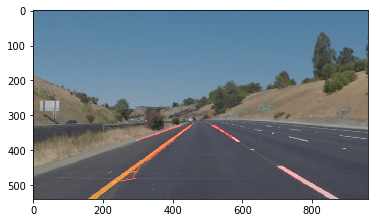

In [32]:
#import image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#printing out some stats and plotting

[image_1,image_2] = process_image(image)

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image_1) # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')# -*- coding: utf-8 -*-



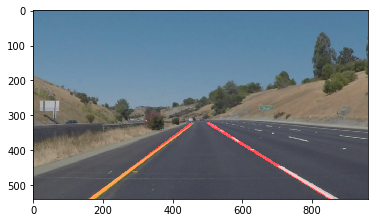

In [33]:
plt.imshow(image_2)